# Introduction to Computer Vision



## Used Libraries

In [2]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

## Camera Module

The Pin-Hole-Camera Model is a widely used camera model in computer vision. <br>

![Pin-Hole-Camera](Pictures/Pin-Hole-Camera.jpg)


>With a pin-hole camera, a 3D point **X** is projected to an image point **x** (both expressed in homogeneous coordinates) as: 

<p style="text-align: center;">λx = PX</p>

>Here, the 3x4 matrix **P** is called the *camera matrix* (*or projection matrx*). Note that the 3D point **X** has four elements in homogeneous coordinates, **X** = [X, Y, Z, W]. The scalar λ is the *inverse depth* of the 3D point and is needed if we want all coordinates to be homogeneous with the last value normalized to one.   

In [3]:
class Camera(object):
    """ Class for representing pin-hole cameras. """

    def __init__(self, P):
        """ Initialize P = K[R|t] camera model. """
        
        self.P = P
        self.K = None # calibration matrix
        self.R = None # rotation
        self.t = None # translation
        self.c = None # camera center

    def project(self, X):
        """ Project points in X (4**n array) and normalize coordinates. """

        x = np.dot(self.P, X)
        for i in range(3):
            x[i] /= x[2]

        return x

    def rotation_matrix(a):
        """ Creates a 3D rotation matrix for rotation around the axis of the vector a """

        R = np.eye(4)
        R[:3, :3] = linalg.expm([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
        return R

    def factor(self):
        """ Factorize the camera matrix into K,R,t as P = K[R|t] """

        # factor first 3*3 part
        K, R = linalg.rq(self.P[:,:3])

        # make diagonal of K positive
        T = np.diag(np.sign(np.diag(K)))
        if linalg.det(T) < 0:
            T[1,1] *= -1

        self.K = np.dot(K,T)
        self.R = np.dot(T,R) # T is its own inverse
        self.t = np.dot(linalg.inv(self.K), self.P[:, 3])

        return self.K, self.R, self.t

    def center(self):
        """ Compue and return the camera center """

        if self.c is not None:
            return self.c

        else:
            # compute c by factoring
            self.factor()
            self.c = -np.dot(self.R.T, self.t)
            return self.c

    

First we need to load the data from our example. In this example we will use the "Model-House" which is one of the Oxformd multi-view datasets. Then we make the points into homogeneous coordinates and create a **Camera** object, with the projection matrix.

### Projecting 3D points

In [4]:
#import camera

# load points
points = np.loadtxt('./Examples/Model_House/house.p3d')
# matrix needs to be transposed becuase it expects the points to be like this:
# X: [[1,3,5,3,4,6,7,4,6,25,7,2,7,4,45,...],
# Y:  [6,-3,6,2,78,2,7,2,4,67,2,6,34,6,...],
# Z:  [2,5,1,545,2,345,6,2,6,2,3,4,6,2,...]
#and not like this:
#   X  Y  Z
# [[3, 6, 2],
#  [2, 6, 2],
#  [5, 2, 7],
#  [9, 0, 1],
#  ...]
# => so we need to change columns and rows
points = points.T
points = np.vstack((points, np.ones(points.shape[1])))
# np.ones(N) returns a array with size N filled with 1s

# setup camera
P = np.hstack((np.eye(3), np.array([[0],[0],[-10]])))
# np.eye(N) creates a identity matrix with dimensions NxN
cam = Camera(P)

Then the points a projected and plotted. Which looks like this:

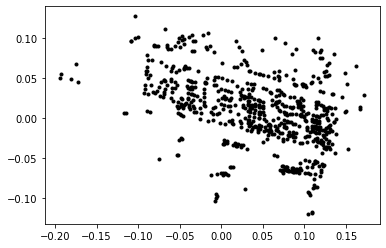

In [5]:
# project the points
x = cam.project(points)

#plot projection
plt.figure()
plt.plot(x[0], x[1], 'k.')
#plt.plot(x[:, 0], x[:, 1], 'k.')
plt.show()

To see the change in projection while moving the camera, we will create the following example:

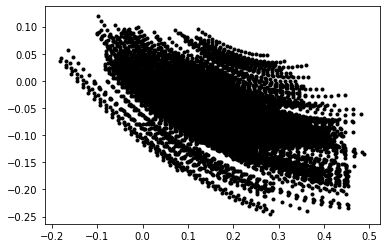

In [6]:
# create transformation
r = 0.05 * np.random.rand(3)
rot = Camera.rotation_matrix(r)

# rotate camera and project
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k.')

plt.show()

This image shows the project after the 3D points have been rotated around a random vector.

## Factoring the Camera Matrix

If we are given the Camera Matrix **P**, we need to be able to recover the internal parameters **K** and the position and pose **t** and **R**. This is called *factorization*. We will use to so called *RQ-factorisation*.   
This is why we need to add the function:
``` python
def factor(self):
```
to the Camera class.

### Computing the Camera Center

It is ver useful to be able to compute the camera's position in space with a given *projection matrix* **P**. The center of the camera **C** is a 3D point with the property P**C** = 0. <br>
For a camera with **P** = **K**[**R**|**t**]    
   
K[R|t]**C** = KR**C** + K**t** = 0   
   
**C** = -R<sup>T</sup> **t**


This is why we need to add the function:
``` python
def center(self):
```
to the Camera class.

## Camera Calibration
Calibrating the camera means determining the internal camera parameters, in our case the matrix **K**. If the application needs precise measurements it is possible to extend the camera modul to inculde radial distortion and other artifacts. For the most part this simple model is enough. In Computer Vision the standard way of calibrating your camera is to take lots of pictures of a flat checkerboard pattern.


### A Simple Calibration Method

- Measeure the sides of your rectangular calibration object. Let's call these d**X** and d**Y**
- Place the camera and the calibration object on a flat surface so that the camer back and calibration object are parallel and the object is roughly in the center of the camera's view. You might have to raise the camera or object to get a nice alignment
- Measure the distance from the camera to the calibration object. Let's call this d**Z**
- Take a picture and check that the setup is straight, meaning that the sides of the calibration object align with the rows and columns of the image
- Measure the width and height of the object in pixels. Let's call these dx and dy

The following relation gives the focal length

$$ f_x = \frac{dx}{dX}\,dZ  ,      f_y = \frac{dy}{dY}\,dZ$$
<br>

In my setup the object was measured to be 175 by 215 mm, d**X** = 175 and d**Y** = 215. The object was 970 mm away form the camera, so d**Z** = 970. The width and height in pixels was 595 and 720. => dx = 595, dy = 720.
Putting these calues into the above formula gives
$$ f_x = \frac{595}{175}\,970 = 3298  , f_y = \frac{720}{215}\,970 = 3248$$

In [8]:
def my_calibration(sz):
    row, col = sz
    fx = 3298*col/4032 #4032 is the camera resolution in width
    fy = 3248*row/3024 #3024 is the camera resolution in height
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row

    return K

IndentationError: expected an indented block (Temp/ipykernel_49860/3602575549.py, line 1)